Per il riconoscimento facciale abbiamo bisogno di seguire i passi indicati nel paper firmato da Turk e Pentland:
- Aquisire un dataset di facce
- Calcolare le eigenfaces dal set di apprendimento conservando solo le M immagini che hanno gli autovalori più alti. Queste M facce rappresentano lo spazio delle facce, questo spazio può essere man mano aggiornato
- Calcolare la distribuzione M dimensionale per ogni individuo proiettando la faccia sullo spazio delle facce

Una volta inizializzato il sistema, possiamo procedere in questo modo:
- Calcolare un set di pesi in base all'immagine fornita e gli autovalori proiettando l'immagine su ogni eigenfaces 
- Determinare se l'immagine è effettivamente un volto controllando che sia abbastanza vicino allo spazio delle facce
- Calcolare i pesi in modo da definire se è una persona che è già segnata o meno
- Opzionalmente si possono aggiornare pesi e spazio delle facce 

In [41]:
import os
import glob 
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pickle
#import pandas as pd
#import math
#from PIL import Image

dim = 64

faces_xml = 'haarcascade_frontalface_alt.xml'
#eyes_xml = 'haarcascade_eye.xml'
face_cascade = cv2.CascadeClassifier()
#eyes_cascade = cv2.CascadeClassifier()
if not face_cascade.load(faces_xml):
    print('--(!)Errore durante il caricamento del file xml per le facce')
    exit(0)


#if not eyes_cascade.load(eyes_xml):
#    print('--(!)Error loading eyes cascade')
#    exit(0)


Caricamento dei percorsi delle foto in un dizionario che verrà poi ciclato per caricare foto e label corrispondenti

In [42]:
root = "foto64x64"
cwd = os.getcwd()
listDir = os.listdir(root)
tagFoto = {}

for dir in listDir:
    imgs =  glob.glob(f"{root}/{dir}/*.jpg")
    tagFoto[dir] = imgs


La funzione normalize prende come parametro un array ndimensionale di numpy e lo normalizza con il metodo minMax, questa operazione ci permette di ottimizzare il processo di calcolo della PCA (si risparmia in media il 50% del tempo) e migliora le approssimazioni

In [43]:
def normalize(matrix):
    normalizedData = (matrix-np.min(matrix))/(np.max(matrix)-np.min(matrix))
    return normalizedData

La funzione violajones prende in input un percorso dalla quale caricare un immagine, in questa specifica implementazione ritorna solo l'ultima faccia letta, questo è un comportamento desiderato in quanto il nostro set di training delle autofacce presenta foto con un unico volto.
La funzione utilizzata per trovare le facce è la detectMultiScale dell'oggetto face_cascade, questa funzione riconosce le facce attraverso una serie di classificatori deboli, è possibile decidere quanti di questi bisogna far attivare per riconoscere effettivamente un volto, di default il parametro è impostato a 3.
I classificatori deboli sono implementati tramite delle matrici che scorrono nell'immagine per trovare i tratti distintivi dei volti, queste matrici sono descritte nel file *haarcascade_frontalface_alt.xlm* cosi come la dimensione del ridimensionamento che viene applicato ciclicamente per rendere i riconoscimenti indipendenti dalla dimensione dell'immagine iniziale, la velocità di ridimensionamento è modificabile tramite il parametro scaleFactor che prevede di ricevere un double che indichi di quanto scalare l'immagine ad ogni iterazione, il suo default è 1.1 che significa ridurre del 10% le dimensioni ad ogni iterazione (ovviamente più iterazioni si fanno fare al detector maggiore sarà la precisione cosi come maggiore sarà il tempo di elaborazione).
Due ulteriori parametri sono molto utili: minSize e maxSize che, attraverso la tupla che accettano in input, definiscono le dimensioni minime e massime per ricoscere un volto.

In [44]:
def violajones(im):
    img = cv2.imread(im,0)
    faceROI = np.zeros((dim,dim), dtype=np.float32)
    faces = face_cascade.detectMultiScale(img)
    for (x, y, w, h) in faces:
        faceROI = img[y:y + h, x:x + w]
        faceROI = cv2.resize(faceROI,(dim,dim), interpolation=cv2.INTER_LINEAR)
        #faceROI = preprocess(faceROI)
        
    return faceROI

Per ottenere il volto medio o caratteristiche comuni di tutti i volti caricati, possiamo sommare tutte le facce che il metodo violajones ritorna per poi dividerle per il numero di volti trovati, otterremo quindi un immagine che ricorda un volto ma che di fatto non ha caratteristiche univoche, questo ci è utile in quanto se da un volto togliamo le caratteristiche comuni (ha due occhi, un naso, una bocca...) otteniamo solo le peculiarità che ci permetteranno di identificare la persona.

Qui viene caricato tutto l'array di foto vettorializzate in una matrice che verrà poi utilizzata per fare la PCA ed ottenere le autofacce.
La matrice viene quindi normalizzata per ridurre gli errori ed ottimizzare tutti i processi

In [45]:
faceMean = np.zeros((dim,dim), dtype=np.float32)
faceNumber = 0
listOfArray = []
faceLabel = []

for key in tagFoto:
    for im in tagFoto[key]:
        vj = violajones(im)
        faceMean += vj
        flat = vj.flat
        listOfArray.append(flat)
        faceLabel.append(key)
        faceNumber+=1

faceMean /= faceNumber

MatrixFlattenedImages = np.vstack(listOfArray)  

MatrixFlattenedImages = normalize(MatrixFlattenedImages)

fig, axes = plt.subplots(1,1,sharex=True,sharey=True,figsize=(3,3))
axes.imshow(faceMean, cmap="gray")
axes.set_title("Faccia media")
plt.show()

KeyboardInterrupt: 

Qui viene svolta e salvata la PCA delle foto raccolte nel set di training, questo passaggio viene svolto solo quando vi è una modifica del set di training, quindi possiamo serializzare il risultato in un file pickle e caricarla quando necessario.

La PCA ci restituisce di fatto i dati di cui abbiamo bisogno, tra cui le autofacce, faccia media ed in generale il nostro spazio dei volti.



Il codice viene lasciato commentato per evitare di utilizzare più tempo del necessario, ma sarà comunque essenziale lanciarlo almeno la prima volta che viene utilizzato il notebook

In [ ]:
#pca = PCA().fit(MatrixFlattenedImages)


#with open('pca.pkl', 'wb') as pickle_file:
#    pickle.dump(pca, pickle_file)

Una volta ricaricato la PCA serializzata, possiamo raccogliere i dati richiesti dall'assigment come il numero di componenti per la varianza al 95%, al 99.99% ed i pesi da utilizzare.

In [ ]:
with open('pca.pkl', 'rb') as pickle_file:
    pca = pickle.load(pickle_file)


varianzaCumulata = pca.explained_variance_ratio_.cumsum()

index95 = list(map(lambda i: i> 0.95, varianzaCumulata)).index(True)

index9999 = list(map(lambda i: i> 0.9999, varianzaCumulata)).index(True)

print(f"numero di componenti per avere il 95%  \t{index95} \nnumero di componenti per avere il 99,99% {index9999} ")

eigenfaces95perc = pca.components_[:index95]
eigenfaces9999perc = pca.components_[:index9999]

eigenfaces = pca.components_

weights = eigenfaces @ (MatrixFlattenedImages - pca.mean_).T
weights95 = eigenfaces95perc @ (MatrixFlattenedImages - pca.mean_).T
weights9999 = eigenfaces9999perc @ (MatrixFlattenedImages - pca.mean_).T


numero di componenti per avere il 95%  	34 
numero di componenti per avere il 99,99% 1341 


Qui viene caricata la galleria dei volti del nostro "mondo chiuso", ovvero lo spazio delle facce che il software può riconoscere attraverso il classificatore KNN, applichiamo quindi le stesse operazioni fatte in precedenza per il training set

In [ ]:
root = "galleria"
listDirGalleria = os.listdir(root)
tagFotoGalleria = {}

for dir in listDirGalleria:
    imgs =  glob.glob(f"{root}/{dir}/*.jpg")
    tagFotoGalleria[dir] = imgs
galleria = []
labelGalleria = []
listOfGalleria = []

for key in tagFotoGalleria:
    for im in tagFotoGalleria[key]:
        img = cv2.imread(im,0)
        img = img.reshape(1,-1)
        listOfGalleria.append(img)
        labelGalleria.append(key)
        
MatrixFlattenedGallery = np.vstack(listOfGalleria)
MatrixFlattenedGallery = normalize(MatrixFlattenedGallery)
indexFotoGalleria = list(np.arange(0,len(labelGalleria)))
pcaGallery = PCA().fit(MatrixFlattenedGallery)
galleryComponent = pcaGallery.components_

Tra i requisiti dell'assignment troviamo la ricerca del miglior compromesso per il classificatore tra un numero di vicini pari ad 1, 3 e 5, quindi creiamo un oggetto KNeighborsClassifier con il parametro relativo impostato con i tre valori e poi ne facciamo il training con la funzione fit.
Il trainign prevede i dati da trovare e le label in quanto è un tipo di training supervisionato, per poter ritrovare le corrispondenze tra label e foto è stato passato un array di lunghezza pari a quello delle label in modo da poterlo passare dopo come indice per farsi restituire nome ed immagine 

In [ ]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(galleryComponent,indexFotoGalleria)
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(galleryComponent,indexFotoGalleria)
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(galleryComponent,indexFotoGalleria)

KNeighborsClassifier()

La funzione knnPredict prende in input un vettore di features di lunghezza 4096 (lunghezza del set di training) e le passa ai tre classificatori e ritorna la previsione

In [ ]:
def knnPredict(query):
    predict1 = knn1.predict(query)
    predict3 = knn3.predict(query)    
    predict5 = knn5.predict(query)

    return predict1, predict3, predict5


Applichiamo quindi ad un immagine di test la previsione per verificare che la label sia corretta

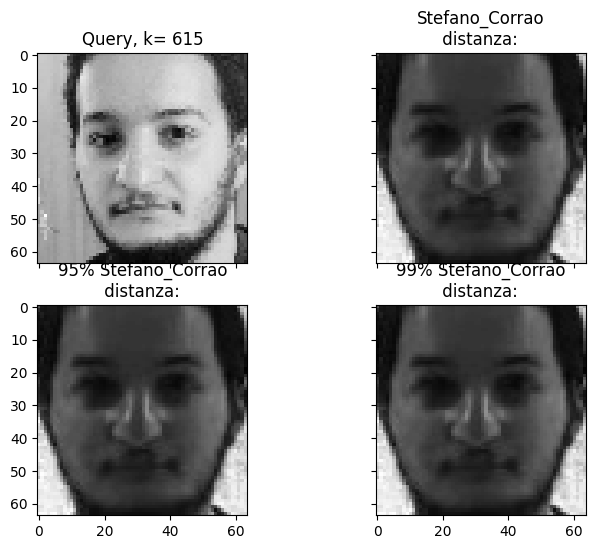

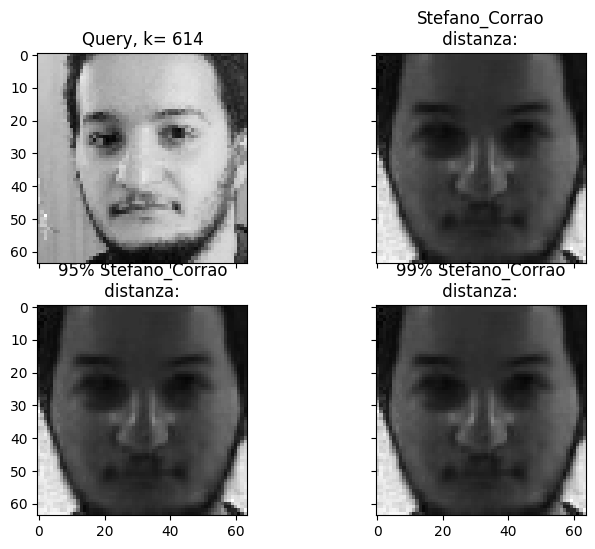

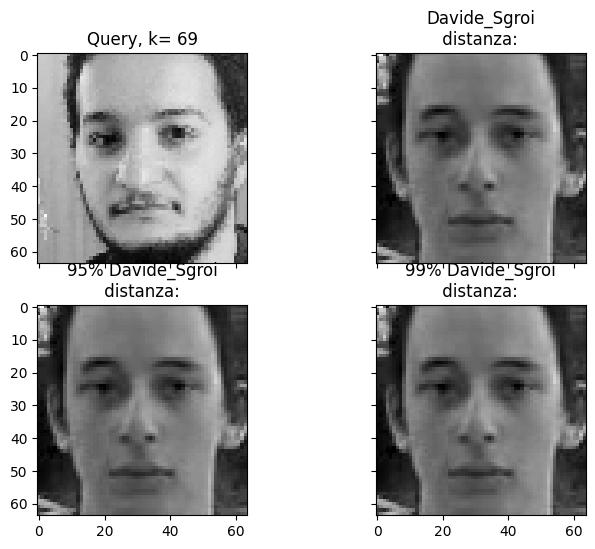

In [ ]:
vj = violajones("test/0.jpg") 
vj = normalize(vj)   
query = vj.reshape(1,-1)

query_weight = eigenfaces @ (query - pca.mean_).T
query_weight = query_weight.reshape(1,-1)
knn100 = knnPredict(query_weight)

for k in knn100:
    fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,6))
    axes[0][0].imshow(query.reshape(dim,dim), cmap="gray")
    axes[0][0].set_title(f"Query, k= {int(k)}")
    axes[0][1].imshow(MatrixFlattenedGallery[int(k)].reshape(dim,dim), cmap="gray")
    axes[0][1].set_title(f"{labelGalleria[int(k)]}\n distanza: ")

    axes[1][0].imshow(MatrixFlattenedGallery[int(k)].reshape(dim,dim), cmap="gray")
    axes[1][0].set_title(f"\n95% {labelGalleria[int(k)]}\n distanza: ")
    axes[1][1].imshow(MatrixFlattenedGallery[int(k)].reshape(dim,dim), cmap="gray")
    axes[1][1].set_title(f"\n99% {labelGalleria[int(k)]}\n distanza: ")


plt.show()

#query_weight95 = eigenfaces95perc @ (query - pca.mean_).T
#print((query_weight95.reshape(1,-1)).shape)
#print(f"\n {knnPredict(query_weight95.reshape(1,-1))}")


#query_weight9999 = eigenfaces9999perc @ (query - pca.mean_).T
#print(f"\n {knnPredict(query_weight9999.reshape(1,-1))}")



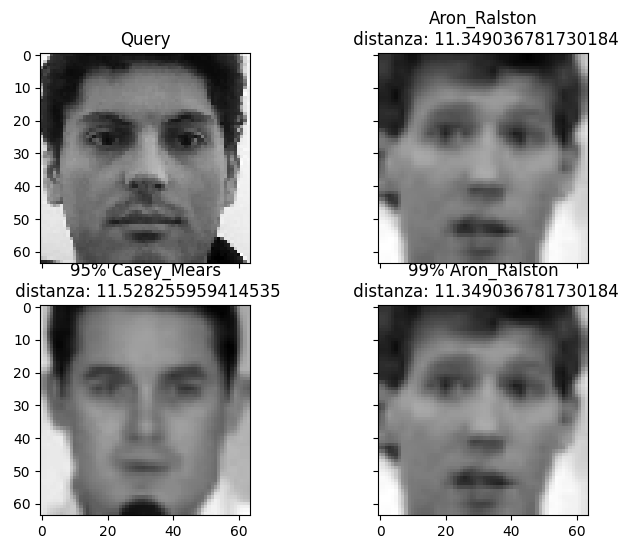

In [ ]:
vj = violajones("test/0.jpg") 
vj = normalize(vj)   
query = vj.reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)

query_weight95 = eigenfaces95perc @ (query - pca.mean_).T
euclidean_distance95 = np.linalg.norm(weights95 - query_weight95, axis=0)

query_weight9999 = eigenfaces9999perc @ (query - pca.mean_).T
euclidean_distance9999 = np.linalg.norm(weights9999 - query_weight9999, axis=0)

best_match = np.argmin(euclidean_distance)

best_match95 = np.argmin(euclidean_distance95)

best_match9999 = np.argmin(euclidean_distance9999)

fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,6))
axes[0][0].imshow(query.reshape(dim,dim), cmap="gray")
axes[0][0].set_title(f"Query")
axes[0][1].imshow(MatrixFlattenedImages[best_match].reshape(dim,dim), cmap="gray")
axes[0][1].set_title(f"{faceLabel[best_match]}\n distanza: {euclidean_distance[best_match]}")

axes[1][0].imshow(MatrixFlattenedImages[best_match95].reshape(dim,dim), cmap="gray")
axes[1][0].set_title(f"\n95% {faceLabel[best_match95]}\n distanza: {euclidean_distance[best_match95]}")
axes[1][1].imshow(MatrixFlattenedImages[best_match9999].reshape(dim,dim), cmap="gray")
axes[1][1].set_title(f"\n99% {faceLabel[best_match9999]}\n distanza: {euclidean_distance[best_match9999]}")


plt.show()




La funzione violajonesMultiple invece è stata impostata per ritornare tutte le facce e le posizioni in un array in quanto sarà necessario per impostare i quadrati ed i nomi sui volti nel video

In [ ]:
def violajonesMultiple(img):
    faceROI = np.zeros((dim,dim), dtype=np.float32)
    faces = face_cascade.detectMultiScale(img, minSize = (10,10), maxSize=(50,50))
    listOfFaceROI = []
    pos =[]
    for (x, y, w, h) in faces:
        faceROI = img[y:y + h, x:x + w]
        faceROI = normalize(cv2.resize(faceROI,(dim,dim), interpolation=cv2.INTER_LINEAR))
        listOfFaceROI.append(faceROI)
        pos.append([(x, y), (x+w, y+h), (255, 0, 255), 4])
    return listOfFaceROI, pos

def findCorrespondence(frame):
    font = cv2.FONT_HERSHEY_SIMPLEX
    faceNumber = 0
    frameFaceLabel = []
    vjMul, pos = violajonesMultiple(frame)
    #print(f"trovati {len(vjMul)} volti nel frame")
    for vj in vjMul:
        vj = normalize(vj)
        query = vj.reshape(1,-1)
        query_weight = eigenfaces @ (query - pca.mean_).T
        #cambiare qui con knn
        best_match = knn5.predict(query_weight.reshape(1,-1))
        frameFaceLabel.append(best_match[0])
    for p in pos:
        px,py = p[0]
        frame = cv2.putText(frame, frameFaceLabel[faceNumber], (px-5,py-5) ,font, 1,(255,255,255),2 )
        faceNumber+=1
        frame = cv2.rectangle(frame, p[0],p[1],p[2],p[3])
    #cv2.imshow("face detect", frame)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    return frame




A questo punto parte il processo di raccolta dei frame e di riconoscimento dei volti, vengono prima messi tutti i frame in un array, a quel punto per ogni frame nell'array vengono riconosciuti i volti.


Attenzione: è richiesta molta memoria durante questa fase del notebook, è consigliabile chiudere le altre finestre per non perdere il lavoro in caso si dovesse verificare qualche evento inaspettato

In [ ]:
video = cv2.VideoCapture("Video finale senza riconoscimento.mp4")
frames = []
if (video.isOpened()== False):
    print("Error opening video file")
while(video.isOpened()):
  ret, frame = video.read()
  if ret == True:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
  else:
      break

riconosciuti=[]
for f in frames:
    riconosciuti.append(findCorrespondence(f))

finito di raccogliere i frame
finito di riconoscere


A questo punto vengono invece ricostruiti i frame in un video da 30 fps, valore trovato dopo dei test per avere un buon compromesso tra la durata del video e la leggibilità 

In [ ]:
with open('Riconosciuto.pkl', 'rb') as pickle_file:
    riconosciuti = pickle.load(pickle_file)
height, width = riconosciuti[0].shape
size = (width,height)

fourcc = -1 

out30 = cv2.VideoWriter('project30fps.mp4',fourcc, 30, size)

for i in riconosciuti:
    out30.write(i)
out30.release()


Video 30 fps fatto


'\nout60 = cv2.VideoWriter(\'project60fps.mp4\',fourcc, 60, size)\n \nfor i in riconosciuti:\n    out60.write(i)\nout60.release()\n\nprint("Video 60 fps fatto")\n\n\nout90 = cv2.VideoWriter(\'project90fps.mp4\',fourcc, 90, size)\n \nfor i in riconosciuti:\n    out90.write(i)\nout90.release()\n\nprint("Video 90 fps fatto")\n'

Domande:
- Come uso i pesi del 95% e 99.99% 
- Come ottengo la distanza dal metodo per decidere quale è meglio
- Come genero le tabelle per comparare i metodi